In [1]:
library(tidyverse)
library(GGally)
library(network)
library(sna)

# Custom package
library(rutils)

-- Attaching packages ---------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

network: Classes for Relational Data
Version 1.16.1 created on 2020-10-06.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation in

In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)

In [3]:
dset_idx <- 3
module_idx <- 3

In [4]:
q_me_thresh <- 0.05
p_mm_thresh <- 0.05
min_hub <- 0.3
# min_hub <- 0.25
# min_hub <- 0
# top_hub <- 0.75
top_hub <- 0.9

In [5]:
network_mm_gs_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_gene_mm_gs.tsv"))
network_me_sig_df <- read_tsv(paste0(dirs$analysis_dir, "/network/", unified_dsets[dset_idx], "_eigengene_traits.tsv"))

lnames <- load(file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_data.RData"))
lnames <- load(file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_network.RData"))

figo_nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_figo_nsmg_list.txt"))


-- Column specification ---------------------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character(),
  module = col_character()
)
i Use `spec()` for the full column specifications.



-- Column specification ---------------------------------------------------------------------------------------------------------------
cols(
  module = col_character(),
  figo_stage_1_cor = col_double(),
  figo_stage_2_cor = col_double(),
  figo_stage_3_cor = col_double(),
  figo_stage_4_cor = col_double(),
  figo_stage_1_pval = col_double(),
  figo_stage_2_pval = col_double(),
  figo_stage_3_pval = col_double(),
  figo_stage_4_pval = col_double(),
  figo_stage_1_qval = col_double(),
  figo_stage_2_qval = col_double(),
  figo_stage_3_qval = col_double(),
  figo_stage_4_qval = col_double(),
  vital_hr = col_double(),
  vital_dev_cor = col_double(),
  vital_pval = col_double(),
  vital_qval = col_double()
)




In [6]:
colnames(tom) <- colnames(data_expr)
rownames(tom) <- colnames(data_expr)
tom_nocyc <- tom - diag(1, nrow(tom))

network_meta_ls <- wgcna_meta(network_me_sig_df, network_mm_gs_df, q_me_thresh, p_mm_thresh, colnames(tom_nocyc))

target_module <- network_meta_ls$modules[module_idx]
# sig_mm_gs_df <- network_mm_gs_df %>% filter(module == target_module, geneID %in% figo_nsmg_list)
sig_mm_gs_df <- network_mm_gs_df %>% filter(module == target_module)

nsmg_mask <- colnames(data_expr) %in% figo_nsmg_list
filt_data_expr <- data_expr[, nsmg_mask]
filt_module_colors <- module_colors[nsmg_mask]

min_hub_df <- get_most_conn_genes(filt_data_expr, filt_module_colors, soft_power, conn_vs_hub_thresh = min_hub) %>%
    bind_rows(.id = "module") %>%
    dplyr::select(geneID, everything()) %>%
#     dplyr::filter(module == target_module, geneID %in% figo_nsmg_list)
    dplyr::filter(module == target_module)

top_hub_df <- get_most_conn_genes(filt_data_expr, filt_module_colors, soft_power, conn_vs_hub_thresh = top_hub) %>%
    bind_rows(.id = "module") %>%
    dplyr::select(geneID, everything()) %>%
#     dplyr::filter(module == target_module, geneID %in% figo_nsmg_list)
    dplyr::filter(module == target_module)

# gene_mask <- colnames(data_expr) %in% network_meta_ls$genes
gene_mask <- (colnames(data_expr) %in% sig_mm_gs_df$geneID) & (colnames(data_expr) %in% min_hub_df$geneID)
tom_nocyc_sig <- tom_nocyc[gene_mask, gene_mask]
adj <- WGCNA::adjacency(filt_data_expr[, filt_module_colors == target_module], power = soft_power, type = "unsigned")
adj_nocyc <- adj - diag(1, nrow(adj))

In [7]:
network_meta_ls$modules

[1] "black"  "green"  "salmon"

In [8]:
module_palette <- list(
    "hub_1" = "steelblue4",
    "nonhub_1" = "steelblue1",
    "hub_2" = "goldenrod4",
    "nonhub_2" = "goldenrod1",
    "hub_3" = "firebrick4",
    "nonhub_3" = "firebrick1"
)

In [9]:
tom_net = network(tom_nocyc_sig, directed = FALSE)

In [10]:
conn_size_map <- c(
    "0.3" = 1,
    "0.4" = 2,
    "0.5" = 3,
    "0.6" = 4,
    "0.7" = 5,
    "0.8" = 6,
    "0.9" = 7,
    "1" = 8
)

In [11]:
conn_size_map

0.3 0.4 0.5 0.6 0.7 0.8 0.9   1 
  1   2   3   4   5   6   7   8

In [12]:
# tom_net %v% "module" = purrr::map(network.vertex.names(tom_net), function(x) { gene_module_table[[x]] })
# tom_net %v% "module" = purrr::map(network.vertex.names(tom_net), function(x) { sig_mm_gs_df %>% filter(geneID == x) %>% pull(module) })
# tom_net %v% "connectivity" = purrr::map(network.vertex.names(tom_net), function(x) { sum(tom_nocyc_sig[x, ]) })
tom_net %v% "conn" = purrr::map(network.vertex.names(tom_net), function(x) { sum(adj_nocyc[x, ]) })
# tom_net %v% "round_pct" = purrr::map(network.vertex.names(tom_net), function(x) { round(sum(adj_nocyc[x, ]), 1) })
tom_net %v% "conn_vs_hub" = purrr::map(tom_net$val, function(x) { min_hub_df %>% filter(geneID == x$vertex.names) %>% pull(conn_vs_hub) %>% round(1) %>% as.character() })
# tom_net %v% "hub" = purrr::map(network.vertex.names(tom_net), function(x) { ifelse(x %in% hub_df$geneID, "hub", "not_hub") })
tom_net %v% "module_color" = purrr::map(network.vertex.names(tom_net), function(x) {
    ifelse(x %in% top_hub_df$geneID, module_palette[[paste0("hub_", module_idx)]], module_palette[[paste0("nonhub_", module_idx)]])
})

In [13]:
tom_net

 Network attributes:
  vertices = 7 
  directed = FALSE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 21 
    missing edges= 0 
    non-missing edges= 21 

 Vertex attribute names: 
    conn conn_vs_hub module_color vertex.names 

No edge attributes

Saving 6.67 x 6.67 in image



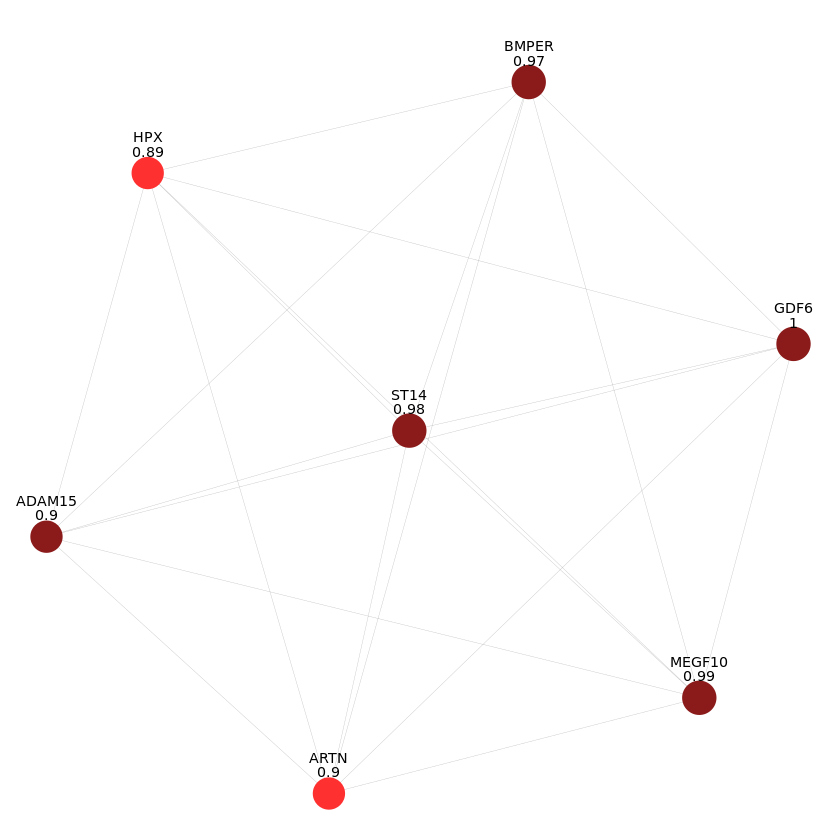

In [14]:
set.seed(123)
# ggnet2(tom_net, edge.size = 0.1, edge.alpha = 0.5, color = "module_color", size = "connectivity", mode = "kamadakawai", size.cut = FALSE) +
ggnet2(tom_net, edge.size = 0.1, edge.alpha = 0.5, color = "module_color", size = "conn_vs_hub", size.palette = conn_size_map, mode = "kamadakawai", size.cut = FALSE) +
    guides(size = FALSE) +
#     geom_point(aes(color = color)) +
    geom_text(aes(label = network.vertex.names(tom_net)), nudge_y = 0.05, size = 3) +
    geom_text(aes(label = purrr::map(tom_net$val, function(x) { min_hub_df %>% filter(geneID == x$vertex.names) %>% pull(conn_vs_hub) %>% round(2) })), nudge_y = 0.03, size = 3) +
ggsave(paste0(dirs$figures_dir, "/network/", unified_dsets[dset_idx], "_module", module_idx, "_hub_genes.png"))